# Introduction

This project demonstrates how to predict the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data using supervised machine learning. Smartphone accelerometers are very precise, and different physical activities give rise to unique patterns of acceleration.

# Input Data

The input data used for training in this project consists of two files.

The first file, train_time_series.csv, contains the raw accelerometer data, which has been collected using the Beiwe research platform, and it has the following format:

timestamp, UTC time, accuracy, x, y, z

The time series signals are sampled at 10 Hz (0.1 seconds per sample) and contains total 3744 samples and 3 components. timestamp column is the time variable. The last three columns labeled x, y, and z correspond to measurements of linear acceleration along each of the three orthogonal axes.

The second file, train_labels.csv, contains the activity labels. Different activities have been encoded with integers as follows:

1 = standing,

2 = walking,

3 = stairs down,

4 = stairs up.

The activity labels are sampled at 1 Hz (1 second per sample) and contains 375 samples. Because the accelerometers are sampled at high frequency, the labels in train_labels.csv are only provided for every 10th observation in train_time_series.csv.
# Method

Here, the goal is to classify the four physical activities from smartphone accelerometer signals as accurately as possible. My approach to build a machine learning classifier is as follows:

The training_labels.csv contain labels for every 10 observations in training_time_series.csv. This implies each labeled signal is sampled from 10 signals.
I combined 3 axes components in training and test time series into a 4th component of combined magnitude by taking a square root of summation of their squares: sqrt(x^2+y^2+z^2)
From 1 & 2 above, I transformed the training_time_series dataframe of shape (3744, 3) into a numpy array of shape (375, 10, 4)
From this array, I extracted features for each of the 4 components using frequency transformations e.g. Fast fourier transformation values, Power spectral density values, Autocorrelation
I split this array of all features into training and validation array in 80:20 ratio. The training set (300 observations) is used to train the classifier. I randomized the training set to avoid classifier getting biased to a particular pattern in time-series
To address the activity class imbalance, I used oversampling with SMOTE on the training set
The validation set (75 observations) is used to get a sense of validation accuracy as an indicator of test accuracy

# Import Modules

In [214]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import scipy.interpolate
import scipy.io as sio
from scipy import stats
import math
from siml.sk_utils import *
from siml.signal_analysis_utils import *
from collections import defaultdict, Counter
from numpy import NaN, Inf, arange, isscalar, asarray, array
from matplotlib.pyplot import plot, scatter, show
from scipy.fftpack import fft
from scipy.signal import welch
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [215]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import scipy.interpolate
import scipy.io as sio
from scipy import stats
import math
from siml.sk_utils import *
from siml.signal_analysis_utils import *
from collections import defaultdict, Counter
from numpy import NaN, Inf, arange, isscalar, asarray, array
from matplotlib.pyplot import plot, scatter, show
from scipy.fftpack import fft
from scipy.signal import welch
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

In [216]:
start=time.process_time()

# Load and View Input Data

In [217]:
train_time_series = pd.read_csv("train_time_series.csv", index_col=0)
train_labels = pd.read_csv("train_labels.csv", index_col=0)
print("Shape of time series signals data:", train_time_series.shape)
print("Shape of labels data:", train_labels.shape)

Shape of time series signals data: (3744, 6)
Shape of labels data: (375, 3)


In [218]:
train_time_series.head()

,timestamp,UTC time,accuracy,x,y,z
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450


In [219]:
def magnitude(activity):
    x2 = activity['x'] * activity['x']
    y2 = activity['y'] * activity['y']
    z2 = activity['z'] * activity['z']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

train_time_series['m'] = magnitude(train_time_series)
train_time_series.head()

,timestamp,UTC time,accuracy,x,y,z,m
20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046,0.937429
20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554,1.021548
20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467,1.037644
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,0.991568
20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,1.012993


In [220]:
train_labels.head()

,timestamp,UTC time,label
20589,1565109931087,2019-08-06T16:45:31.087,1
20599,1565109932090,2019-08-06T16:45:32.090,1
20609,1565109933092,2019-08-06T16:45:33.092,1
20619,1565109934094,2019-08-06T16:45:34.094,1
20629,1565109935097,2019-08-06T16:45:35.097,1


# Cleaning train dataset

In [221]:
everytenth=range(20589,24330,10) #access only every 10th observation, the ones labeled
reduc_train_time=train_time_series.loc[everytenth]
remain_train_time=train_time_series.drop(index=everytenth)

reduc_train_time['label']=train_labels['label'] #merge the two datasets into one by creating one column for labels 

reduc_train_time

,timestamp,UTC time,accuracy,x,y,z,m,label
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,0.991568,1
20599,1565109932090,2019-08-06T16:45:32.090,unknown,0.013718,-0.852371,-0.000870,0.852482,1
20609,1565109933092,2019-08-06T16:45:33.092,unknown,0.145584,-1.007843,-0.036819,1.018969,1
20619,1565109934094,2019-08-06T16:45:34.094,unknown,-0.099380,-1.209686,0.304489,1.251372,1
20629,1565109935097,2019-08-06T16:45:35.097,unknown,0.082794,-1.001434,-0.025375,1.005171,1
...,...,...,...,...,...,...,...,...
24289,1565110302030,2019-08-06T16:51:42.030,unknown,-0.641953,-1.469177,0.301041,1.631322,4
24299,1565110303032,2019-08-06T16:51:43.032,unknown,-0.171616,-0.366074,-0.059082,0.408598,4
24309,1565110304034,2019-08-06T16:51:44.034,unknown,0.401810,-1.077698,0.258911,1.178948,4
24319,1565110305037,2019-08-06T16:51:45.037,unknown,0.330338,-1.470062,0.303894,1.537061,4


In [222]:
pd.DataFrame.from_dict(Counter(train_labels['label']), orient="index", columns=['label']).reset_index()

,index,label
0,1,27
1,2,213
2,4,47
3,3,88


# Time-series Data Visualization

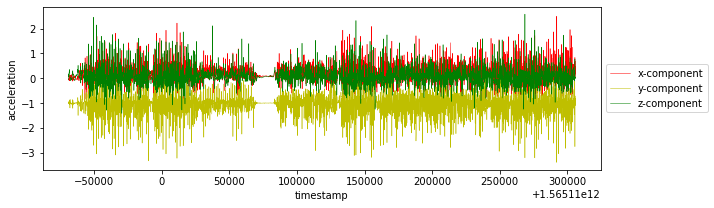

In [223]:
plt.figure(figsize=(10,3))
plt.plot(train_time_series['timestamp'], train_time_series['x'], linewidth=0.5, color='r', label='x-component')
plt.plot(train_time_series['timestamp'], train_time_series['y'], linewidth=0.5, color='y', label='y-component')
plt.plot(train_time_series['timestamp'], train_time_series['z'], linewidth=0.5, color='g', label='z-component')
plt.xlabel('timestamp')
plt.ylabel('acceleration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

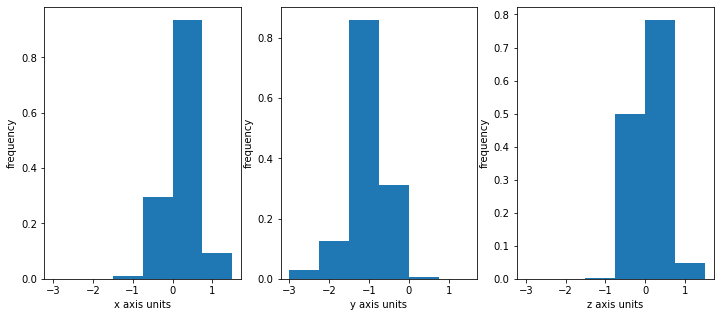

In [224]:
#visual inspection of common punctuations in x,y and z variables in general
plt.figure(figsize=(12,5))
for position,covar in [(131,'x'),(132,'y'),(133,'z')]:
    plt.subplot(position)
    plt.hist(reduc_train_time[covar],density=True,bins=np.linspace(-3,1.5,7)) 
    plt.xlabel(covar+' axis units')
    plt.ylabel('frequency')

In [225]:
standing=reduc_train_time[reduc_train_time['label']==1]
walking=reduc_train_time[reduc_train_time['label']==2]
stairsdown=reduc_train_time[reduc_train_time['label']==3]
stairsup=reduc_train_time[reduc_train_time['label']==4]

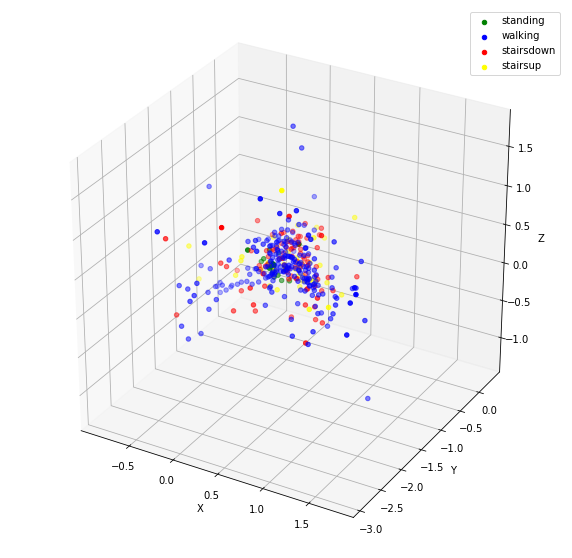

In [226]:
#3d plot with the xyz covariables
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(standing['x'],standing['y'],standing['z'],c='green',label='standing')
ax.scatter(walking['x'],walking['y'],walking['z'],c='blue',label='walking')
ax.scatter(stairsdown['x'],stairsdown['y'],stairsdown['z'],c='red',label='stairsdown')
ax.scatter(stairsup['x'],stairsup['y'],stairsup['z'],c='yellow',label='stairsup')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

# Data Visulization by Activity

In [227]:
# Separating data for each activity
train_df = pd.concat([train_time_series, train_labels['label']], axis=1).dropna()
columns = ['timestamp', 'x', 'y', 'z', 'm', 'label']

standing = train_df[columns][train_df.label == 1]
walking = train_df[columns][train_df.label == 2]
stairsdown = train_df[columns][train_df.label == 3]
stairsup = train_df[columns][train_df.label == 4]

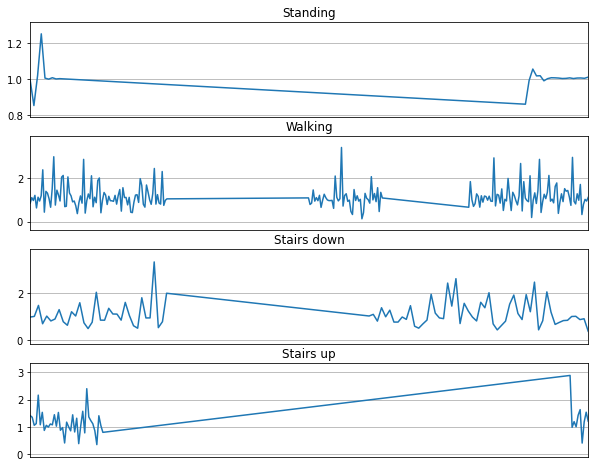

In [228]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(10, 8))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['timestamp'], activities[i]['m'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

plot_activity([standing, walking, stairsdown, stairsup],
              ['Standing', 'Walking', 'Stairs down', 'Stairs up'])

# Sampling Time and Frequency

In [229]:
print("Origital datatype of UTC time:", type(train_time_series['UTC time'].iloc[1]))
train_time_series['UTC time'] =  pd.to_datetime(train_time_series['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')
train_labels['UTC time'] =  pd.to_datetime(train_labels['UTC time'], format='%Y-%m-%dT%H:%M:%S.%f')
print("Updated datatype of UTC time:", type(train_time_series['UTC time'].iloc[1]))

Origital datatype of UTC time: <class 'str'>
Updated datatype of UTC time: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [230]:
# Sampling time and frequency for time series signals 
T_train_time_series = np.mean([train_time_series['UTC time'].iloc[i+1]-train_time_series['UTC time'].iloc[i] for i in range(len(train_time_series['UTC time'])-1)])
f_train_time_series = len(train_time_series['UTC time'])/(train_time_series['UTC time'].iloc[-1]-train_time_series['UTC time'].iloc[0]).total_seconds()

print("Time-series signals - \nAverage time per sample: {:.2f} seconds\nFrequency per sample: {:.2f} Hz".\
      format(T_train_time_series.total_seconds(), f_train_time_series))

# Sampling time and frequency for labels
T_train_label = np.mean([train_labels['UTC time'].iloc[i+1]-train_labels['UTC time'].iloc[i] for i in range(len(train_labels['UTC time'])-1)])
f_train_label = len(train_labels['UTC time'])/(train_labels['UTC time'].iloc[-1]-train_labels['UTC time'].iloc[0]).total_seconds()

print("\nActivity labels - \nAverage time per sample: {:.2f} seconds\nFrequency per sample: {:.2f} Hz".\
      format(T_train_label.total_seconds(), f_train_label))

Time-series signals - 
Average time per sample: 0.10 seconds
Frequency per sample: 9.98 Hz

Activity labels - 
Average time per sample: 1.00 seconds
Frequency per sample: 1.00 Hz


# Creating Signals and Labels Arrays

In [231]:
train_x_list = [train_time_series.x.iloc[start:start+10] for start in range(len(train_labels))]
train_y_list = [train_time_series.y.iloc[start:start+10] for start in range(len(train_labels))]
train_z_list = [train_time_series.z.iloc[start:start+10] for start in range(len(train_labels))]
train_m_list = [train_time_series.m.iloc[start:start+10] for start in range(len(train_labels))]
train_signals = np.transpose(np.array([train_x_list, train_y_list, train_z_list, train_m_list]), (1, 2, 0))
train_labels = np.array(train_labels['label'].astype(int))

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
no_labels = len(np.unique(train_labels[:]))

print("The train signals array contains {} signals, each one of length {} and {} components ".format(no_signals_train, no_steps_train, no_components_train))
print("The train labels array contains {} labels, with the following distribution:\n {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))

The train signals array contains 375 signals, each one of length 10 and 4 components 
The train labels array contains 375 labels, with the following distribution:
 Counter({2: 213, 3: 88, 4: 47, 1: 27})


In [232]:
def randomize(dataset, labels):
   permutation = np.random.permutation(labels.shape[0])
   shuffled_dataset = dataset[permutation, :]
   shuffled_labels = labels[permutation]
   return shuffled_dataset, shuffled_labels

train_signals, train_labels = randomize(train_signals, np.array(train_labels))

# Frequency Transformation Functions

In [233]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [(1/f_s) * kk for kk in range(0,len(y_values))]
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values
    
def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features_ft(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y
 
def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features_ft(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features_ft(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features_ft(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)

# Applying and Visualizing Frequency Transformations

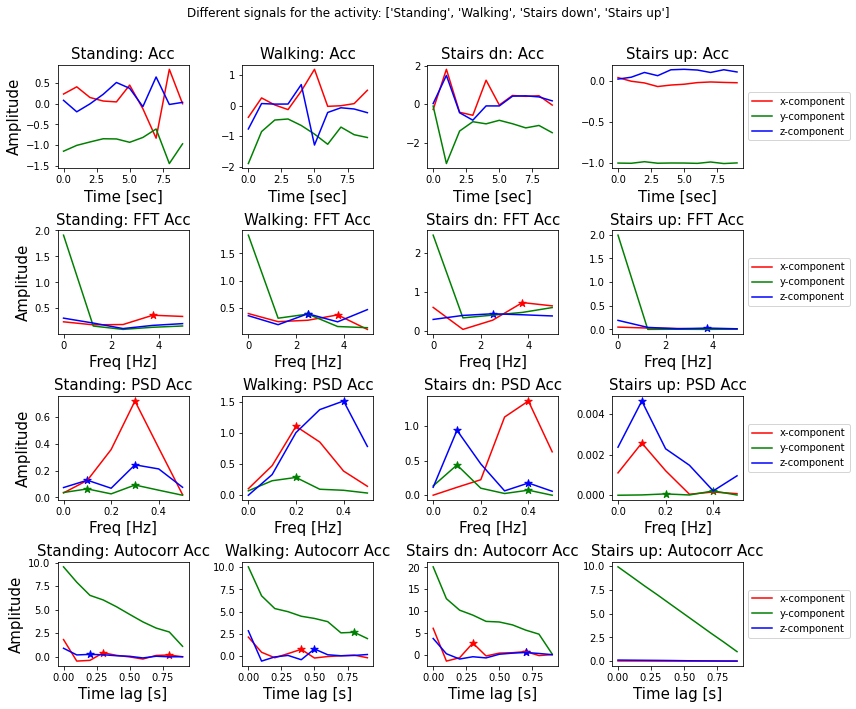

In [234]:
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"

activities_description = {
    1: 'Standing',
    2: 'Walking',
    3: 'Stairs down',
    4: 'Stairs up'
}
N = 10
f_s = 1 #1 Hz for train_labels #10 Hz for train_time_series 
t_n = 1 #1 sec for train_labels #0.1 sec for train_time_series
T = t_n / N 
sample_rate = 1 / f_s
denominator = 10
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'

axtitles = [['Standing: Acc', 'Walking: Acc', 'Stairs dn: Acc', 'Stairs up: Acc'],
            
            ['Standing: FFT Acc', 'Walking: FFT Acc', 'Stairs dn: FFT Acc', 'Stairs up: FFT Acc'],
            
            ['Standing: PSD Acc', 'Walking: PSD Acc', 'Stairs dn: PSD Acc', 'Stairs up: PSD Acc'],
            
            ['Standing: Autocorr Acc', 'Walking: Autocorr Acc', 'Stairs dn: Autocorr Acc', 'Stairs up: Autocorr Acc']
           ]

list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]
signal_no_list = [5, 20, 160, 120]
activity_name = list(activities_description.values())

f, axarr = plt.subplots(nrows=4, ncols=4, figsize=(12,10))
f.suptitle(suptitle.format(activity_name), fontsize=12)
 
for row_no in range(0,4):
    for col_no in range(0,4):
        for comp_no in range(0,3):
            color = colors[comp_no % 3]
            label = labels[comp_no % 3]

            axtitle  = axtitles[row_no][col_no]
            xlabel = xlabels[row_no]
            value_retriever = list_functions[row_no]

            ax = axarr[row_no][col_no]
            ax.set_title(axtitle, fontsize=15)
            ax.set_xlabel(xlabel, fontsize=15)
            
            if col_no == 0:
                ax.set_ylabel(ylabel, fontsize=15)

            signal_no = signal_no_list[col_no]
            signals = train_signals[signal_no, :, :]
            signal_component = signals[:, comp_no]
            
            x_values, y_values = value_retriever(signal_component, T, N, f_s)
            
            ax.plot(x_values, y_values, linestyle='-', color=color, label=label)            
            if row_no > 0:
                max_peak_height = 0.1 * np.nanmax(y_values)
                indices_peaks = detect_peaks(y_values, mph=max_peak_height)
                ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
            if col_no == 3:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

# Visualisation in 3D

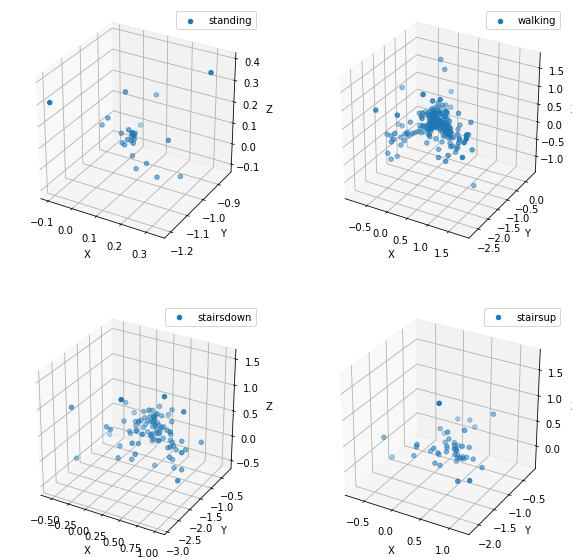

In [235]:
fig = plt.figure(figsize=(10,10))
def subplot(df,label,position):
    ax = fig.add_subplot(position,projection='3d')
    ax.scatter(df['x'],df['y'],df['z'],label=label)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper right')
    
subplot(standing,'standing',221)
subplot(walking,'walking',222)
subplot(stairsdown,'stairsdown',223)
subplot(stairsup,'stairsup',224)


# Extract Frequency Transformed Features

In [236]:
reduc_train_time['UTC time']=pd.to_datetime(reduc_train_time['UTC time'],utc=True)
reduc_train_time['UTC time'].head()

20589   2019-08-06 16:45:31.087000+00:00
20599   2019-08-06 16:45:32.090000+00:00
20609   2019-08-06 16:45:33.092000+00:00
20619   2019-08-06 16:45:34.094000+00:00
20629   2019-08-06 16:45:35.097000+00:00
Name: UTC time, dtype: datetime64[ns, UTC]

# pattern of activity

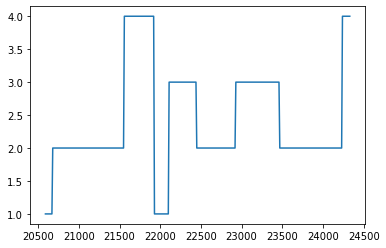

In [237]:
times=reduc_train_time['UTC time']
elapsed_time=[time-times[20589] for time in times]
ind=reduc_train_time.index
lab=reduc_train_time['label']
plt.plot(ind,lab);

   #     Exploratory analysis using statistics

In [238]:
import researchpy as rp
print('general info:',reduc_train_time.describe())
print(rp.summary_cat(reduc_train_time['label']))
print('xxxx'*18)
for df in [standing,walking,stairsdown,stairsup]:
    print(rp.summary_cont(df[['x','y','z']]))

general info:           timestamp           x           y           z           m  \
count  3.750000e+02  375.000000  375.000000  375.000000  375.000000   
mean   1.565110e+12    0.214254   -1.009747    0.092230    1.140217   
std    1.086802e+05    0.391877    0.457594    0.352037    0.510088   
min    1.565110e+12   -0.863419   -2.919434   -1.248840    0.133861   
25%    1.565110e+12    0.014862   -1.152794   -0.061554    0.856976   
50%    1.565110e+12    0.203979   -0.954330    0.058731    1.010501   
75%    1.565110e+12    0.428375   -0.769676    0.216187    1.289474   
max    1.565110e+12    1.785187    0.321747    1.741806    3.426598   

            label  
count  375.000000  
mean     2.413333  
std      0.799287  
min      1.000000  
25%      2.000000  
50%      2.000000  
75%      3.000000  
max      4.000000  
  Variable  Outcome  Count  Percent
0    label        2    213    56.80
1                 3     88    23.47
2                 4     47    12.53
3                 1   

In [239]:
# CLEANING TEST DATA
everytenth=range(24339,25589,10) # access only every 10th observation, the ones labeled
reduc_test_time=test_time_series.loc[everytenth]
remain_test_time=test_time_series.drop(index=everytenth)

reduc_test_time['label']=test_labels['label'] # merge the two datasets into one by creating one column for labels 
reduc_test_time

,timestamp,UTC time,accuracy,x,y,z,label
24339,1565110307041,2019-08-06T16:51:47.041,unknown,0.098282,-0.833771,0.118042,2
24349,1565110308043,2019-08-06T16:51:48.043,unknown,0.348465,-0.946701,-0.051041,2
24359,1565110309046,2019-08-06T16:51:49.046,unknown,0.377335,-0.849243,-0.026474,2
24369,1565110310048,2019-08-06T16:51:50.048,unknown,0.110077,-0.520325,0.312714,3
24379,1565110311050,2019-08-06T16:51:51.050,unknown,0.283478,-0.892548,-0.085876,3
...,...,...,...,...,...,...,...
25539,1565110427366,2019-08-06T16:53:47.366,unknown,-0.043915,-0.242416,0.068802,2
25549,1565110428369,2019-08-06T16:53:48.369,unknown,0.118271,-1.212097,0.357468,2
25559,1565110429371,2019-08-06T16:53:49.371,unknown,0.667404,-0.978851,0.171906,2
25569,1565110430373,2019-08-06T16:53:50.373,unknown,0.371384,-1.021927,-0.244446,2


#   Visualisation of different models

        # Logistic Regression
        # Random Forest Classifier
        # KNearestNeighbour

In [240]:
#Load input train and test datas
X=np.array(reduc_train_time[['x','y','z']])
y=np.array(reduc_train_time['label'])
test=np.array(reduc_test_time[['x','y','z']])

   #  1. Logistic Regression

In [241]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5)
model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [242]:
# Logistic Regression: Accuracy
print(model.score(X_test,y_test))

0.5957446808510638


In [243]:
# Logistic regression: Classification report
print(classification_report(y_test,model.predict(X_test),zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        13
           2       0.60      1.00      0.75       112
           3       0.00      0.00      0.00        42
           4       0.00      0.00      0.00        21

    accuracy                           0.60       188
   macro avg       0.15      0.25      0.19       188
weighted avg       0.35      0.60      0.44       188



# 2. Random Forest Classifier

In [244]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5)
forestmodel=RandomForestClassifier()
forestmodel.fit(X_train,y_train)

RandomForestClassifier()

In [245]:
print(forestmodel.score(X_test,y_test))

0.5478723404255319


In [246]:
print(classification_report(y_test,forestmodel.predict(X_test)))

              precision    recall  f1-score   support

           1       0.64      0.75      0.69        12
           2       0.59      0.78      0.67       109
           3       0.32      0.16      0.22        43
           4       0.22      0.08      0.12        24

    accuracy                           0.55       188
   macro avg       0.44      0.44      0.43       188
weighted avg       0.49      0.55      0.50       188



# 3. KNearestNeighbour

In [247]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5)
knnmodel=KNeighborsClassifier(n_neighbors=5)
knnmodel.fit(X_train,y_train)

KNeighborsClassifier()

In [248]:
knnmodel.predict(X_test)

array([2, 1, 3, 2, 3, 2, 4, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2,
       2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3,
       2, 2, 3, 2, 2, 1, 2, 2, 3, 1, 2, 2, 2, 3, 2, 2, 3, 1, 2, 3, 2, 1,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 1, 2, 3, 2, 2, 2, 2, 1, 2, 3, 1, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 3, 1, 3, 2, 2, 2, 1, 4, 2, 1, 2], dtype=int64)

In [249]:
knnmodel.score(X_test,y_test)

0.5638297872340425

In [250]:
print(classification_report(y_test,knnmodel.predict(X_test)))

              precision    recall  f1-score   support

           1       0.71      0.60      0.65        20
           2       0.58      0.82      0.68       100
           3       0.43      0.26      0.32        46
           4       0.00      0.00      0.00        22

    accuracy                           0.56       188
   macro avg       0.43      0.42      0.41       188
weighted avg       0.49      0.56      0.51       188



# 4.Gradient Boosting Classifier

In [251]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.5)
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [252]:
GradientBoostingClassifier()
clf.predict(X_test[:2])

array([2, 2], dtype=int64)

In [253]:
clf.score(X_test, y_test)

0.5425531914893617

In [264]:
print('mean score logistic ',np.mean(logistic))
print('mean score forest ',np.mean(forest))
print('mean score knn ',np.mean(knn))
print('mean score clf ',np.mean(clf))

mean score logistic  0.5489758179231863
mean score forest  0.5473968705547654
mean score knn  0.5628165007112375
mean score clf  nan


In [265]:
stats.ttest_ind(logistic,forest, equal_var = False)

Ttest_indResult(statistic=0.08164291670172623, pvalue=0.9360179376389353)

In [266]:
stats.ttest_ind(knn,forest, equal_var = False)

Ttest_indResult(statistic=0.659717138006897, pvalue=0.517788293777381)

In [267]:
stats.ttest_ind(logistic,knn, equal_var = False)

Ttest_indResult(statistic=-0.7143497628113367, pvalue=0.4860754591509162)

In [268]:
X_train=np.array(reduc_train_time[['x','y','z']])
y_train=np.array(reduc_train_time['label'])
test=np.array(reduc_test_time[['x','y','z']])

final_model=KNeighborsClassifier(n_neighbors=5)
final_model.fit(X_train,y_train)

final_model.predict(test)

array([2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 3, 3, 1, 2, 2, 1, 2, 3, 2, 2, 2, 3,
       2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 2, 3, 2, 2, 1, 2, 2, 3, 2,
       3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 4, 2, 2, 2, 2, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 2, 2,
       3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [269]:
label_predictions=final_model.predict(test)
test_labels['label']=label_predictions
test_labels.to_csv('test labels.csv')

In [270]:
end=time.process_time()
total=end-start
print(total,'seconds')

13.140625 seconds


# Result
A model trained on tri-axial smartphone accelerometer data in different models as shown below 
    Logistic Regression
    Random Forest Classifier
    KNearestNeighbour
    GradientBoostingclassifier
Visualisation of dataset in various ways    